 # Count And Identify Trees

In [1]:
import rasterio
from rasterio.transform import from_origin
from rasterio.windows import Window
from rasterio import logging as rasterio_logging
from deepforest import main
from deepforest import utilities
import ffmpeg
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
from PIL import Image as PILImage

rasterio_logger = rasterio_logging.getLogger()
rasterio_logger.setLevel(rasterio_logging.ERROR)

In [2]:
class SrtParser:
    def __init__(self,path):
        self.path = path
        file_to_read = open(path,'r')
        self.data = file_to_read.read()
        file_to_read.close()
        self.subtitles = pd.DataFrame(columns=['index','start','end','text','latitude','longitude','distance','height','horizontal_speed','vertical_speed'])

    def parseTime(self,time_str):
        # Extract hours, minutes, and seconds from the time string
        hours, minutes, seconds_milliseconds = time_str.split(':')
        seconds, milliseconds = seconds_milliseconds.split(',')
        
        # Convert hours, minutes, and seconds to integers
        hours = int(hours)
        minutes = int(minutes)
        seconds = int(seconds)
        milliseconds = int(milliseconds)
        
        # Return the total number of milliseconds
        return (hours * 3600 + minutes * 60 + seconds) * 1000 + milliseconds


    def parseSubtitle(self,subtitle_str):
        # Split the subtitle string into lines
        lines = subtitle_str.strip().split('\n')
        
        # Extract the index, start, and end times from the first line
        index = int(lines[0])
        start, end = map(self.parseTime, lines[1].split(' --> '))
        
        # Join the remaining lines into a single string
        text = '\n'.join(lines[2:])
        
        # Create and return a Subtitle object
        new_subtitle = pd.DataFrame.from_dict({
            'index': [index],
            'start': [start],
            'end': [end],
            'text': [text],
            'longitude': [float(text.split(',')[4].lstrip('GPS ('))],
            'latitude': [float(text.split(',')[5])],
            'distance': [float(text.split(',')[7].lstrip('D ').rstrip('m'))],
            'height': [float(text.split(',')[8].lstrip('H ').rstrip('m'))],
            'horizontal_speed': [float(text.split(',')[9].lstrip('H.S ').rstrip('m/s'))],
            'vertical_speed': [float(text.split(',')[10].lstrip('V.S ').rstrip('m/s'))]
        })
        self.subtitles = pd.concat([self.subtitles,new_subtitle],ignore_index=True)

    def parseSrt(self,srt_str):
        # Split the srt string into a list of subtitle strings
        subtitles = re.split('\n\n+', srt_str.strip())
        
        # Parse each subtitle string and return a list of Subtitle objects
        for subtitle in subtitles:
            self.parseSubtitle(subtitle)
        return self.subtitles
    
    def parse(self):
        return self.parseSrt(self.data)

In [3]:
def prepareEnv(envName):
    #If a path or filename is provided the env name is the basename of the given filename.
    envName = os.path.basename(envName).split('.')[0]

    if not os.path.exists('data'):
        os.makedirs('data')
    envPath = 'data/%s'%envName
    if not os.path.exists(envPath):
        os.makedirs(envPath)
    srcImgsPath = '%s/srcImgs'%envPath
    if not os.path.exists(srcImgsPath):
        os.makedirs(srcImgsPath)
    geoImgsPath = '%s/geoImgsPath'%envPath
    if not os.path.exists(geoImgsPath):
        os.makedirs(geoImgsPath)

    config = {
        'envName': envName,
        'envPath': envPath,
        'srcImgsPath': srcImgsPath,
        'geoImgsPath': geoImgsPath,
        'metaSrtFile': '%s/subs.srt' % envPath,
        'srcImgsFile': '%s/%s'%(srcImgsPath,"src_%05d.png")
    }

    return config


In [4]:

def extractMetaFromVideo(videoFileName): 
    config = prepareEnv(videoFileName)
    ffmpeg.input(videoFileName).output(config['metaSrtFile'], map = "0:s:0").run(overwrite_output=True)

In [5]:
def createSrcImgs(videoFileName):
    config = prepareEnv(videoFileName)
    ffmpeg.input(videoFileName).output(config['srcImgsFile'],vf='crop=ih:ih,scale=400:-1',r=1).run(overwrite_output=True)

In [6]:
def generateGeoCodeImage(videoFileName,second,latidute,longitude):
    config = prepareEnv(videoFileName)
    src = rasterio.open('%s/src_%05d.png'%(config['srcImgsPath'],second))
    width, height = src.width, src.height
    size = min(width, height)

    # Set the metadata for the GeoTIFF
    meta = {
        'driver': 'GTiff',
        'dtype': 'uint8',
        'nodata': 0,
        'width': size,
        'height': size,
        'count': 3,
        'crs': rasterio.crs.CRS.from_epsg(4326),  # Set the CRS to EPSG: 4326 (WGS 84)
        'transform': from_origin(latidute, longitude, 0.7, 0.7)  # Set the latitude and longitude coordinates as the origin
    }

    # Create the GeoTIFF file
    with rasterio.open('%s/geo_%05d.tiff'%(config['geoImgsPath'],second), 'w', **meta) as dst:
        x_offset = (width - size) // 2
        y_offset = (height - size) // 2
        window = Window(x_offset, y_offset, size, size)

        # Copy the data from the source image to the GeoTIFF
        dst.write(src.read(window=window))

    src.close()

In [7]:
def generateGeoCodeImagewithPIL(videoFileName,second,latidute,longitude):
    config = prepareEnv(videoFileName)
    img = PILImage.open('%s/src_%05d.png'%(config['srcImgsPath'],second))

    width, height = img.size
    resolution = 400

    if width > height:
        left = (width - height) / 2
        top = 0
        right = (width + height) / 2
        bottom = height
    else:
        left = 0
        top = (height - width) / 2
        right = width
        bottom = (height + width) / 2
    img = img.crop((left, top, right, bottom))
    img = img.resize((resolution,resolution))

    # Save the resized image as a GeoTIFF file
    img.save('%s/geo_%05d.tiff'%(config['geoImgsPath'],second), format="TIFF", dtype=float,  geotransform=(longitude,resolution,0, latidute,0, -resolution))


In [8]:
class AI:
    def __init__(self):
        self.main = main.deepforest()
        self.main.use_release(check_release=False)
        self.predictedTrees = False
        
    def predictAsDf(self,videoFileName,second):
        config = prepareEnv(videoFileName)
        path = '%s/geo_%05d.tiff'%(config['geoImgsPath'],second)
        r = rasterio.open(path)
        transform = r.transform 
        crs = r.crs
        r.close()

        df = self.main.predict_image(path=path)
        gdf = utilities.annotations_to_shapefile(df, transform=transform, crs=crs)
        if self.predictedTrees is False:
            self.predictedTrees = gdf
        else:
            self.predictedTrees = pd.concat([self.predictedTrees,gdf],axis=0)
        return gdf
    
    def predictAsImg(self,videoFileName,second):
        config = prepareEnv(videoFileName)
        path = '%s/geo_%05d.tiff'%(config['geoImgsPath'],second)
        return self.main.predict_image(path=path,return_plot=True,thickness=5)
    
    def toCsv(self,videoFileName):
        config = prepareEnv(videoFileName)
        if self.predictedTrees is not False:
            self.predictedTrees.to_csv('%s/predictions.csv'%config['envPath'],index=False)

In [9]:
videoFileName = "/Users/hakanonal/Downloads/temp_video_for_share.mp4"
config = prepareEnv(videoFileName)

In [10]:
extractMetaFromVideo(videoFileName)

ffmpeg version N-109428-g10a56363a7-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static

In [11]:
srtParser = SrtParser(config['metaSrtFile'])
metaData = srtParser.parse()
metaData

index   start     end                                               text  \
0       1       0    1000  F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...   
1       2    1000    2000  F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...   
2       3    2000    3000  F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...   
3       4    3000    4000  F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...   
4       5    4000    5000  F/2.8, SS 1122.74, ISO 110, EV 0, GPS (28.0279...   
..    ...     ...     ...                                                ...   
306   307  306000  307000  F/2.8, SS 242.51, ISO 100, EV 0, GPS (28.0274,...   
307   308  307000  308000  F/2.8, SS 242.51, ISO 100, EV 0, GPS (28.0274,...   
308   309  308000  309000  F/2.8, SS 242.51, ISO 100, EV 0, GPS (28.0274,...   
309   310  309000  310000  F/2.8, SS 245.15, ISO 100, EV 0, GPS (28.0274,...   
310   311  310000  311000  F/2.8, SS 250.51, ISO 100, EV 0, GPS (28.0274,...   

     latitude  longitude  distance  height  horizontal_speed  vertical_speed  
0     38.5969    28.0279     23.50     2.9              0.00             0.0  
1     38.5969    28.0279     23.45     2.9              0.20             0.0  
2     38.5969    28.0279     23.79     2.9              0.71             0.0  
3     38.5969    28.0279     24.69     2.9              1.41             0.0  
4     38.5969    28.0279     26.19     2.8              2.02             0.0  
..        ...        ...       ...     ...               ...             ...  
306   38.5964    28.0274     57.10    32.4              1.63             0.0  
307   38.5964    28.0274     55.54    32.4              1.63             0.0  
308   38.5964    28.0274     53.98    32.4              1.61             0.0  
309   38.5964    28.0274     52.44    32.5              1.63             0.0  
310   38.5964    28.0274     50.92    32.5              1.61             0.0  

[311 rows x 10 columns]

In [12]:
# No need to execute this everytime. Un-comment and execute it when analyzing a fresh video create images from video for each second.
#createSrcImgs(videoFileName)

ffmpeg version N-109428-g10a56363a7-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static

/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Reading config file: /Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/data/deepforest_config.yml
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = Dat

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


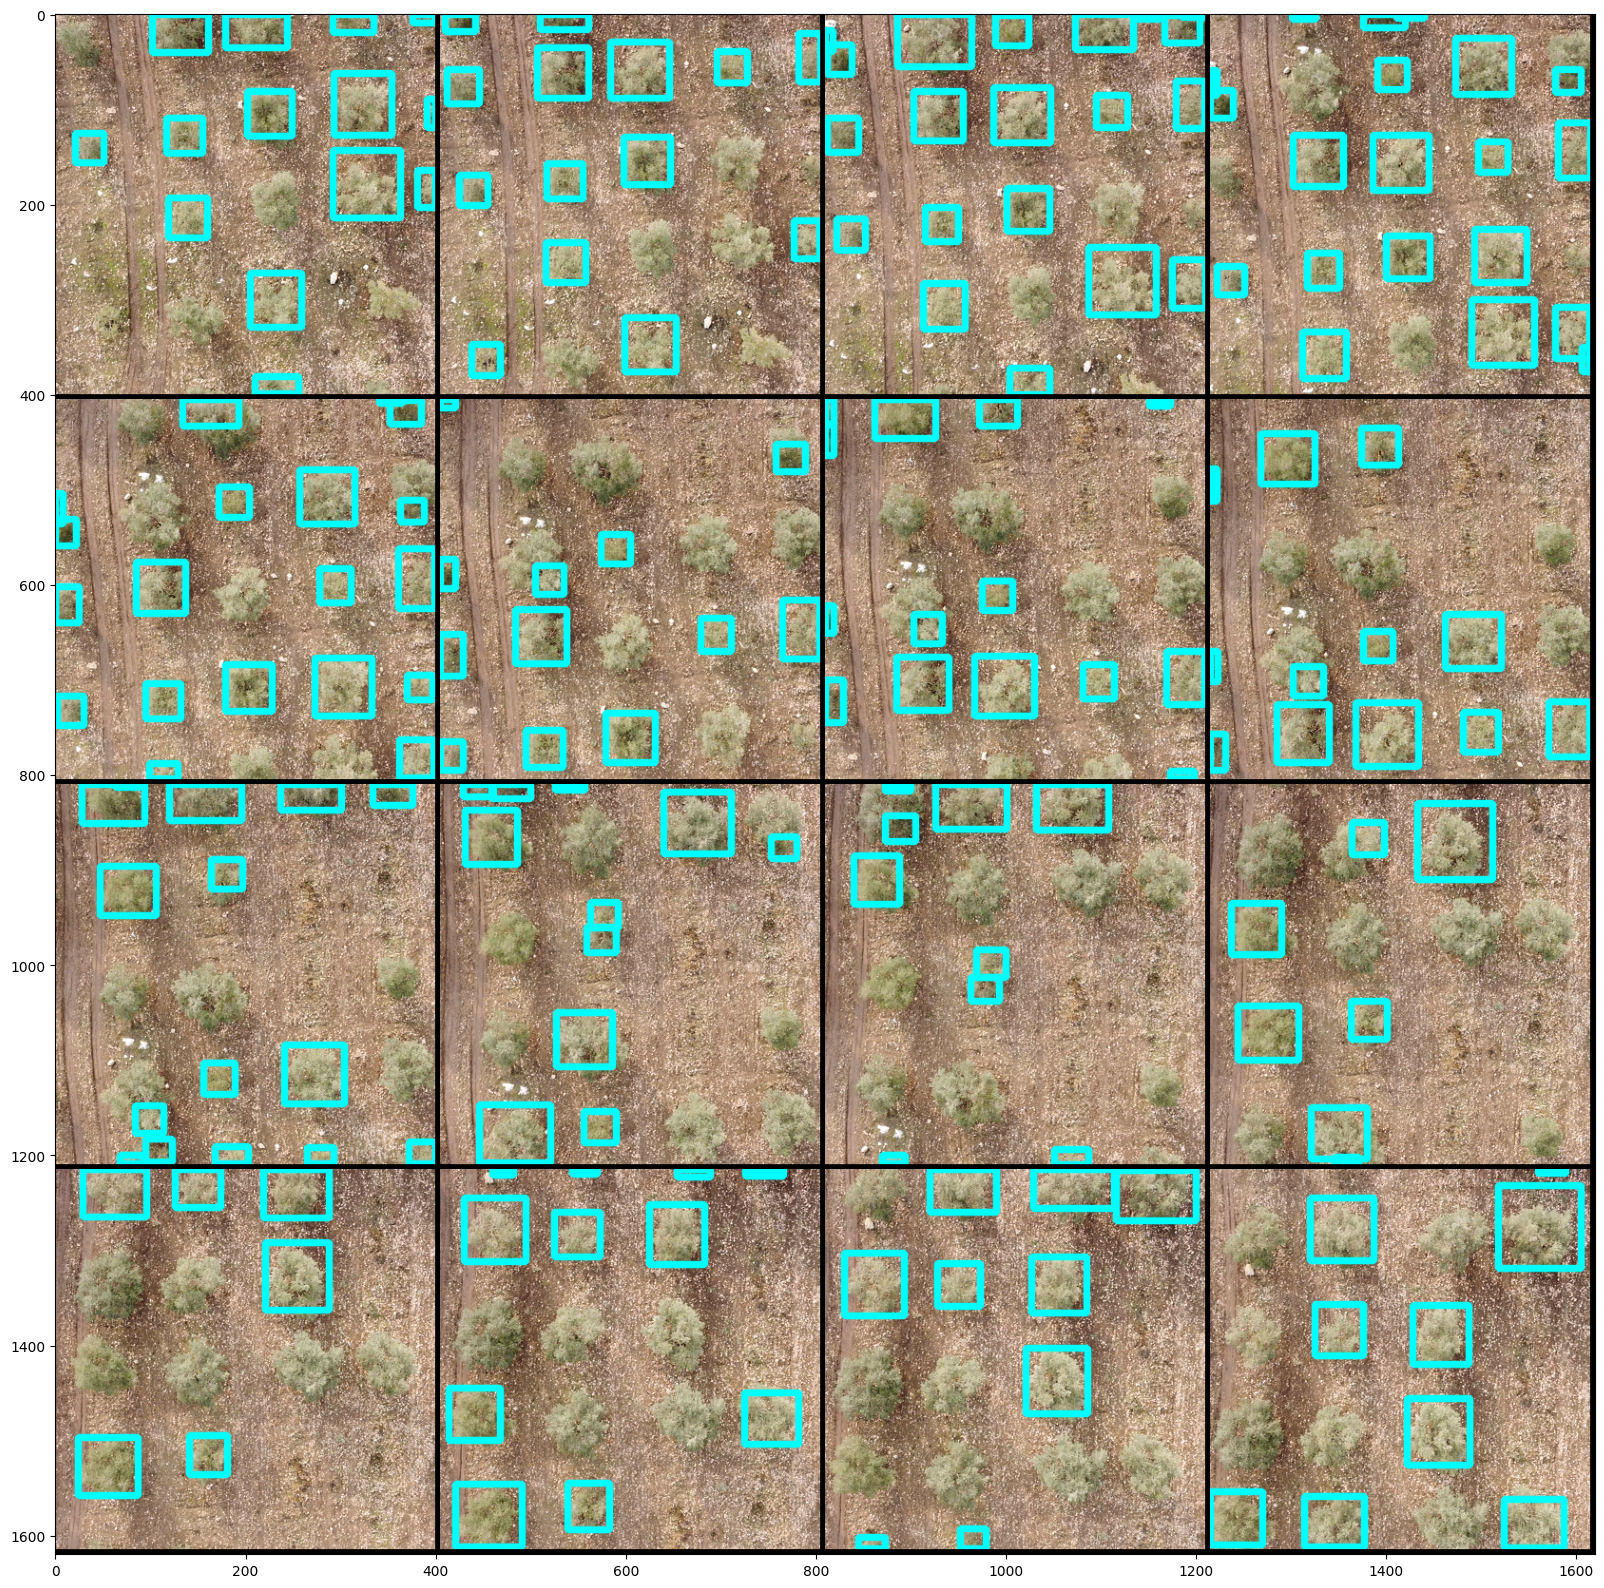

In [13]:
def predict_concequtive_images_and_tile_in_a_plt():
    tile = 4
    size=400
    margin=5
    results = []
    row=[]
    df = False

    ai = AI()
    for k in range(190,206):
        generateGeoCodeImage(videoFileName,k,metaData.latitude[k],metaData.longitude[k])
        img = ai.predictAsImg(videoFileName,k)
        gdf = ai.predictAsDf(videoFileName,k)
        i = ((k-190) // tile)
        j = (k-190) % tile
        row.append(img[:,:,::-1])
        row.append(np.zeros((size,margin,3),dtype=int))
        if j == (tile - 1):
            rows = np.concatenate(row, axis=1 )
            results.append(rows)
            results.append(np.zeros((margin,(size+margin)*tile,3),dtype=int))
            row=[]
    results = np.concatenate(results, axis=0 )
    ai.toCsv(videoFileName)

    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()
predict_concequtive_images_and_tile_in_a_plt()
